# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

In [3]:
print(mnist_train)

<BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>


# Model creation

In [4]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=1,padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same'))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))


# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(NUM_CLASSES))


# Teacher loss function

In [5]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.
  

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)



  return cross_entropy_loss_value

# Student loss function

In [6]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)

  return ALPHA * cross_entropy_loss_value + (1- ALPHA) * distillation_loss_value

# Train and evaluation

In [7]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      correct_results,_,_ = compute_num_correct(model, images, labels)
      num_correct += correct_results


    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

In [8]:
# your code start from here for step 5 
train_and_evaluate(cnn_model, compute_teacher_loss)
cnn_model.save("task1_teacher_model")
train_and_evaluate(fc_model, compute_student_loss)
fc_model.save("task1_student_model")

Epoch 1: Class_accuracy: 98.25%
Epoch 2: Class_accuracy: 98.62%
Epoch 3: Class_accuracy: 98.84%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 98.93%
Epoch 6: Class_accuracy: 99.01%
Epoch 7: Class_accuracy: 99.09%
Epoch 8: Class_accuracy: 99.11%
Epoch 9: Class_accuracy: 99.14%
Epoch 10: Class_accuracy: 99.11%
Epoch 11: Class_accuracy: 99.17%
Epoch 12: Class_accuracy: 99.15%


INFO:tensorflow:Assets written to: task1_teacher_model\assets


INFO:tensorflow:Assets written to: task1_teacher_model\assets


Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.21%
Epoch 4: Class_accuracy: 98.58%
Epoch 5: Class_accuracy: 98.70%
Epoch 6: Class_accuracy: 98.83%
Epoch 7: Class_accuracy: 98.84%
Epoch 8: Class_accuracy: 98.75%
Epoch 9: Class_accuracy: 98.81%
Epoch 10: Class_accuracy: 98.75%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.81%


INFO:tensorflow:Assets written to: task1_student_model\assets


INFO:tensorflow:Assets written to: task1_student_model\assets


# Test accuracy vs. tempreture curve

current tempreature is  1
Epoch 1: Class_accuracy: 98.56%
Epoch 2: Class_accuracy: 98.75%
Epoch 3: Class_accuracy: 98.64%
Epoch 4: Class_accuracy: 98.68%
Epoch 5: Class_accuracy: 98.67%
Epoch 6: Class_accuracy: 98.65%
Epoch 7: Class_accuracy: 98.60%
Epoch 8: Class_accuracy: 98.35%
Epoch 9: Class_accuracy: 98.54%
Epoch 10: Class_accuracy: 98.56%
Epoch 11: Class_accuracy: 98.54%
Epoch 12: Class_accuracy: 98.61%
Class_accuracy: 98.61%
current tempreature is  2
Epoch 1: Class_accuracy: 98.52%
Epoch 2: Class_accuracy: 98.49%
Epoch 3: Class_accuracy: 98.47%
Epoch 4: Class_accuracy: 98.66%
Epoch 5: Class_accuracy: 98.69%
Epoch 6: Class_accuracy: 98.69%
Epoch 7: Class_accuracy: 98.72%
Epoch 8: Class_accuracy: 98.25%
Epoch 9: Class_accuracy: 98.44%
Epoch 10: Class_accuracy: 98.51%
Epoch 11: Class_accuracy: 98.54%
Epoch 12: Class_accuracy: 98.69%
Class_accuracy: 98.69%
current tempreature is  4
Epoch 1: Class_accuracy: 98.53%
Epoch 2: Class_accuracy: 98.57%
Epoch 3: Class_accuracy: 98.60%
Epoch 

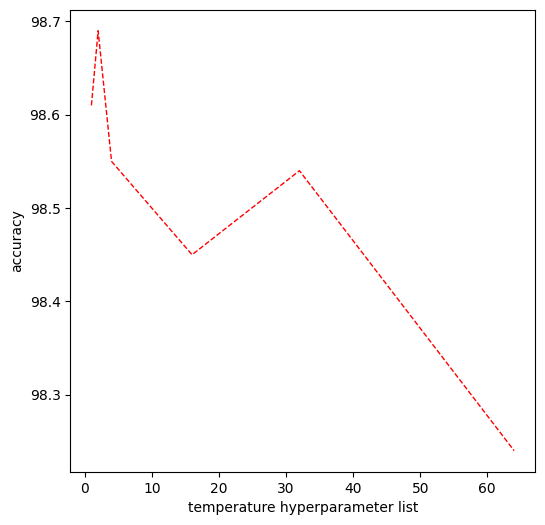

In [23]:
# your code start from here for step 6
import matplotlib
from matplotlib import pyplot as plt

ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_LIST = [1,2,4,16,32,64] #temperature hyperparameter list
accuracy_list = []

for temp_single in DISTILLATION_TEMPERATURE_LIST:
  
  print('current tempreature is ', temp_single)
  DISTILLATION_TEMPERATURE = temp_single
  train_and_evaluate(fc_model, compute_student_loss)
  
  # Run evaluation.
  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  
  for images, labels in mnist_test:
    # your code start from here for step 4
    correct_results,_,_ = compute_num_correct(fc_model, images, labels)
    num_correct += correct_results

  print("Class_accuracy: " + '{:.2f}%'.format(
      num_correct / num_total * 100))

  accuracy_list.append(num_correct / num_total * 100)


plt.figure(figsize=(6,6))
plt.xlabel("temperature hyperparameter list")
plt.ylabel("accuracy")
plt.plot(DISTILLATION_TEMPERATURE_LIST,accuracy_list,color='r',linewidth=1.0,linestyle='--')
plt.show()

# Train student from scratch

In [9]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(NUM_CLASSES))


#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.92%
Epoch 2: Class_accuracy: 97.88%
Epoch 3: Class_accuracy: 97.32%
Epoch 4: Class_accuracy: 97.78%
Epoch 5: Class_accuracy: 97.96%
Epoch 6: Class_accuracy: 98.08%
Epoch 7: Class_accuracy: 98.33%
Epoch 8: Class_accuracy: 97.89%
Epoch 9: Class_accuracy: 97.18%
Epoch 10: Class_accuracy: 98.22%
Epoch 11: Class_accuracy: 98.21%
Epoch 12: Class_accuracy: 98.06%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [10]:
# your code start from here for step 8
# !pip install keras_flops

from keras_flops import get_flops

teacher_model_flops = get_flops(cnn_model, batch_size=1)
student_model_flops = get_flops(fc_model, batch_size=1)

print('The flops of teacher model is',teacher_model_flops)
print('The flops of student model is',student_model_flops)

cnn_model.summary()
fc_model.summary()


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


The flops of teacher model is 32792714
The flops of student model is 2475882
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                             

# Implementing the state-of-the-art KD algorithm

In [17]:
# your code start from here for step 12
# Seyed Iman Mirzadeh, Mehrdad Farajtabar, Ang Li, Nir Levine, Akihiro Matsukawa, and Hassan Ghasemzadeh. 
# Improved knowledge distillation via teacher assistant. 
# In Proceedings of the AAAI Conference on Artificial Intelligence, volume 34, pages 5191–5198, 2020. 
# https://ojs.aaai.org/ index.php/AAAI/article/view/5963/5819

# Build Teacher assistant.
ta_model = tf.keras.Sequential()
ta_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
ta_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=1,padding='same'))
ta_model.add(tf.keras.layers.Flatten())
ta_model.add(tf.keras.layers.Dense(784, activation='relu'))
ta_model.add(tf.keras.layers.Dense(784, activation='relu'))
ta_model.add(tf.keras.layers.Dropout(0.5))
ta_model.add(tf.keras.layers.Dense(NUM_CLASSES))

def compute_ta_or_student_loss(images, labels, learn_model, teach_model):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = learn_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = teach_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)

  return ALPHA * cross_entropy_loss_value + (1- ALPHA) * distillation_loss_value

def train_and_evaluate_state_of_the_art(model, teach_model):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_ta_or_student_loss(images, labels, model, teach_model)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      correct_results,_,_ = compute_num_correct(model, images, labels)
      num_correct += correct_results


    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

# train teacher assistant model
train_and_evaluate_state_of_the_art(ta_model, teach_model=cnn_model)
ta_model.save("task1_ta_model")

# train student model from teacher assistant model
train_and_evaluate_state_of_the_art(fc_model, teach_model=ta_model)
ta_model.save("task1_student_from_ta_model")

Epoch 1: Class_accuracy: 96.80%
Epoch 2: 

In [14]:
ta_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 784)               19669776  
                                                                 
 dense_15 (Dense)            (None, 784)               615440    
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                      

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
